In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from highlight_text import fig_text
from pyfonts import load_font
from utils import add_labels, get_label_rotation

df1 = pd.read_csv("data/employment-rates.csv")
df1["metric"] = "unemployment"
df1.rename(columns={
    "unemployment_rate": "value"
}, inplace=True)
df1_female = df1[df1["sex"]=="Female"]
df1_male = df1[df1["sex"]=="Male"]
df1 = df1_female.merge(
    df1_male,
    left_on=["island", "year", "age", "metric"],
    right_on=["island", "year", "age", "metric"],
    how="inner",
    suffixes=("_female", "_male")
)

df2 = pd.read_csv("data/education-level.csv")
df2.replace({
   "Early childhood education": "Highschool and below",
   "Primary education": "Highschool and below",
   "Lower secondary education": "Highschool and below",
   "Upper secondary education": "Highschool and below",
   "Post-secondary non-tertiary education": "After highschool",
   "Tertiary education": "After highschool"
}, inplace=True)
df2["metric"] = "n_people_educated"
df2.rename(columns={
    "count": "value"
}, inplace=True)
df2_female = df2[df2["sex"]=="Female"]
df2_male = df2[df2["sex"]=="Male"]
df2 = df2_female.merge(
    df2_male,
    left_on=["island", "year", "age", "level", "metric"],
    right_on=["island", "year", "age", "level", "metric"],
    how="inner",
    suffixes=("_female", "_male")
).sample(60)

df3 = pd.read_csv("data/management-position.csv")
df3.drop(columns="categories", inplace=True)
df3["metric"] = "share-manager"
df3.rename(columns={
    "share_female_lead": "value"
}, inplace=True)
df3["value_male"] = 100 - df3["value"]
df3.rename(columns={"value": "value_female"}, inplace=True)

df = pd.concat([df1, df2, df3])
df.drop(columns=["sex_male", "sex_female", "level"], inplace=True)
df.replace("Micronesia (Federated States of)", "Micronesia", inplace=True)
df["name"] = ""

max_per_metric = df.groupby("metric")[["value_female", "value_male"]].max().reset_index()
max_per_metric.columns = ["metric", "max_female", "max_female"]
df = df.merge(max_per_metric, on="metric")
df["max"] = df[['max_female', 'max_female']].max(axis=1)
df["value_female_scaled"] = df["value_female"]/df["max"]
df["value_male_scaled"] = df["value_male"]/df["max"]
df.sort_values(by=["metric", "island"], inplace=True)
df

,island,year,value_female,age,metric,value_male,name,max_female,max_female,max,value_female_scaled,value_male_scaled
24,Kiribati,2020,7166.00,25-54,n_people_educated,552.00,,20090.00,12489.0,20090.00,0.356695,0.027476
25,Kiribati,2020,7166.00,25-54,n_people_educated,8590.00,,20090.00,12489.0,20090.00,0.356695,0.427576
26,Kiribati,2020,11118.00,25-54,n_people_educated,8590.00,,20090.00,12489.0,20090.00,0.553410,0.427576
27,Kiribati,2020,47.00,55-64,n_people_educated,137.00,,20090.00,12489.0,20090.00,0.002339,0.006819
28,Kiribati,2020,86.00,55-64,n_people_educated,35.00,,20090.00,12489.0,20090.00,0.004281,0.001742
...,...,...,...,...,...,...,...,...,...,...,...,...
16,Tuvalu,2015,12.92,25-54,unemployment,13.16,,36.63,24.7,36.63,0.352716,0.359268
17,Tuvalu,2017,16.25,25-54,unemployment,16.73,,36.63,24.7,36.63,0.443625,0.456729
18,Tuvalu,2017,9.23,55-64,unemployment,18.07,,36.63,24.7,36.63,0.251979,0.493311
19,Vanuatu,2019,7.37,25-54,unemployment,5.36,,36.63,24.7,36.63,0.201201,0.146328


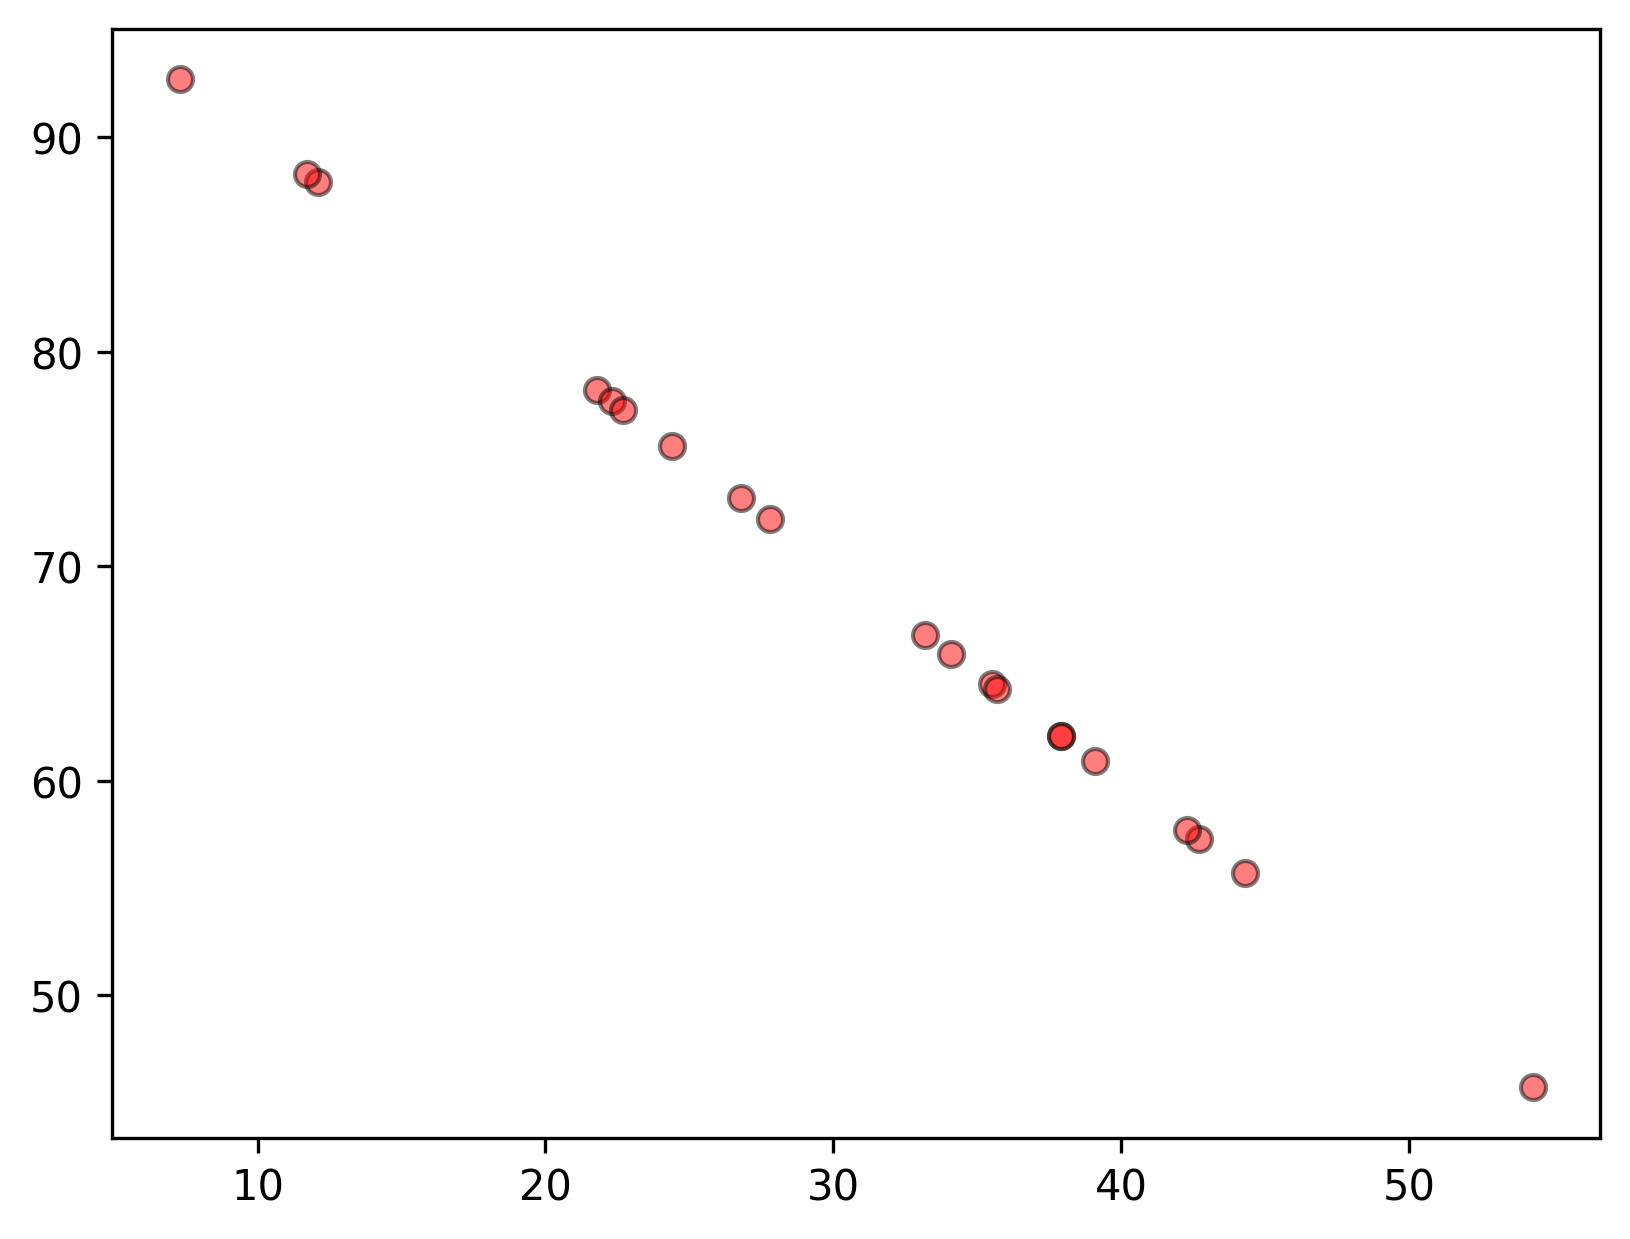

In [100]:
data = df[df["metric"]=="share-manager"]
fig, ax = plt.subplots(dpi=300)
ax.scatter(
   data["value_female"],
   data["value_male"],
   color="red",
   edgecolor="black",
   linewidth=1,
   alpha=0.5,
   zorder=3
)

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

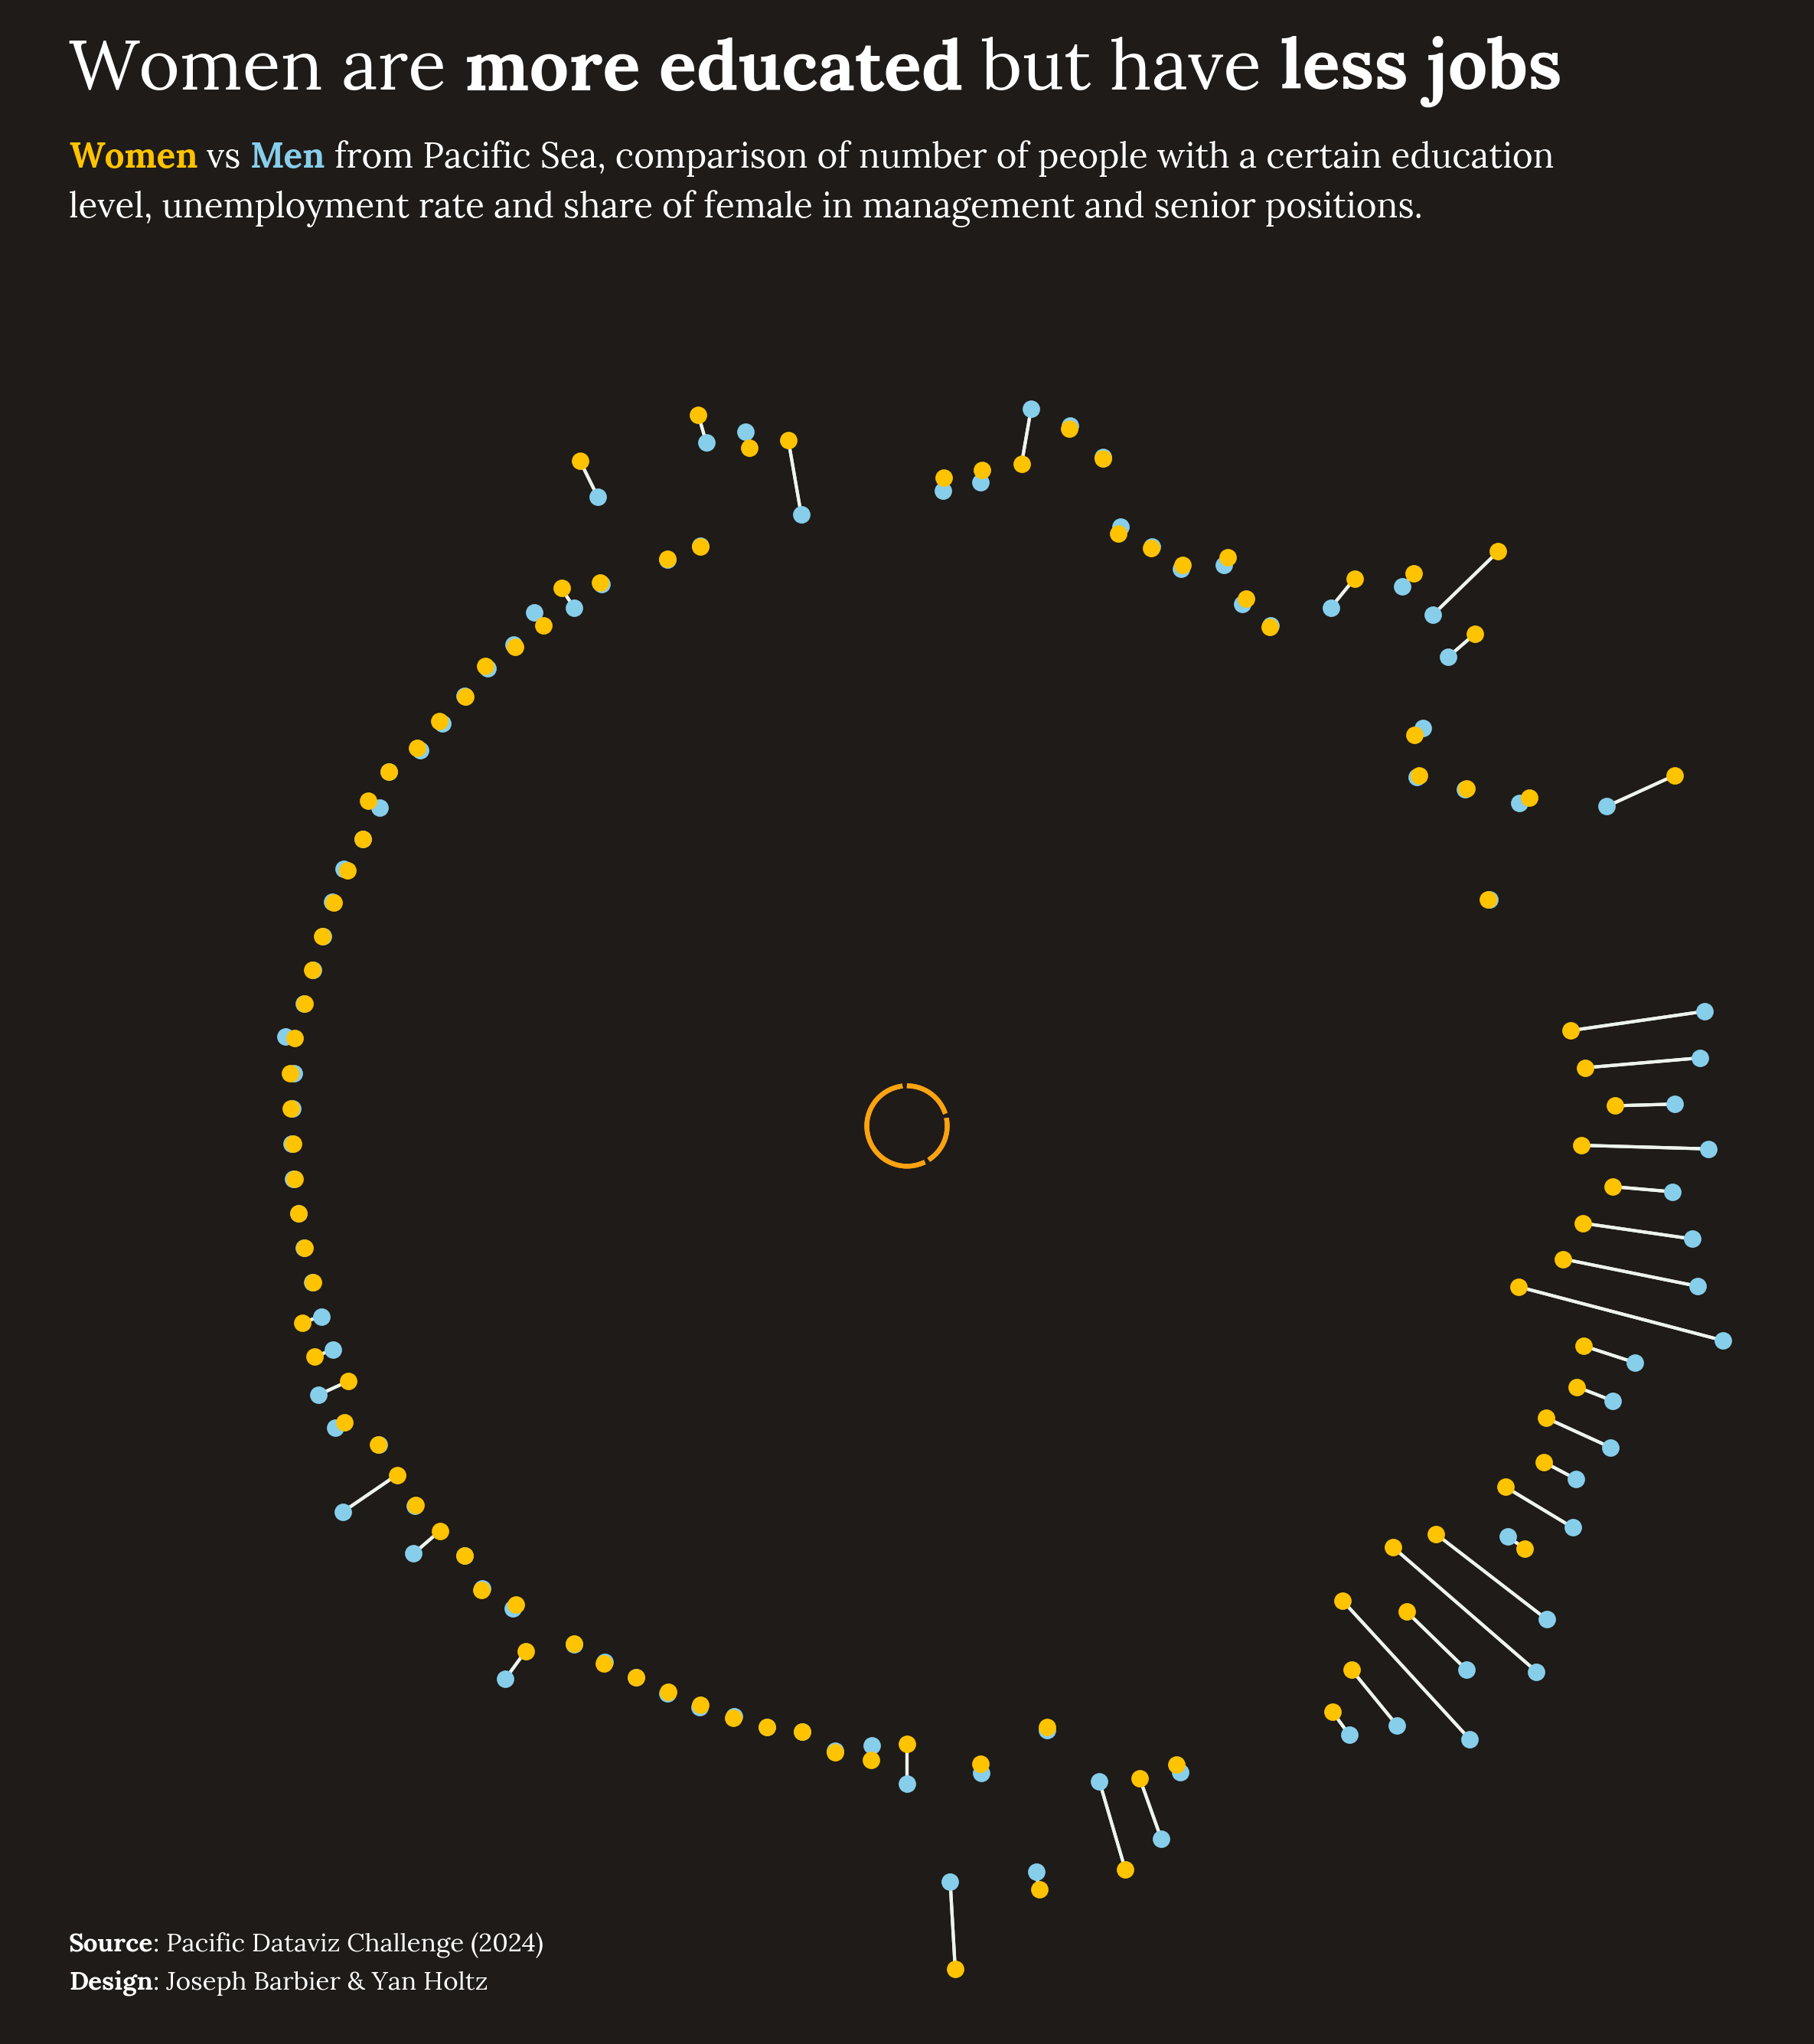

In [87]:
def circular_lollipop(df, value, name, group, fig, ax, color, other_values):
    VALUES = df[value].values*2
    OTHER_VALUES = df[other_values].values*2
    LABELS = df[name].values
    GROUP = df[group].values

    PAD = 3
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)

    GROUPS_SIZE = [len(i[1]) for i in df.groupby(group)]

    offset = 0
    IDXS = []
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    ax.set_theta_offset(np.pi/2)
    #ax.set_ylim(-120, 120)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    GROUPS_SIZE = [len(i[1]) for i in df.groupby(group)]
    COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

    # Calculate the minimum and maximum values for each pair
    BOTTOMS = np.minimum(VALUES, OTHER_VALUES)
    TOPS = np.maximum(VALUES, OTHER_VALUES)

    # Plot lines
    for angle, bottom, top in zip(ANGLES[IDXS], BOTTOMS, TOPS):
        ax.plot([angle, angle], [bottom, top], color=line_col, linewidth=1)

    # Plot markers
    ax.scatter(ANGLES[IDXS], VALUES, color=color, s=20, zorder=10)

    # Add labels
    for angle, value, label in zip(ANGLES[IDXS], VALUES, LABELS):
        ha = 'left' if np.pi/2 <= angle <= 3*np.pi/2 else 'right'
        ax.text(angle, value + 5, label, ha=ha, va='center', rotation=np.degrees(angle - np.pi/2), font=font)

    offset = 0 
    for group, size in zip(np.unique(GROUP), GROUPS_SIZE):
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
        ax.plot(x1, [-5] * 50, color=curvedline_col)
        ax.text(
            np.mean(x1), -20, group, color=curvedline_col, fontsize=10, 
            fontweight="bold", ha="center", va="center", font=font
        )
        
        offset += size + PAD

#parameters
background_col = "#1e1b18"
curvedline_col = "#fca311"
line_col = "#eef4ed"
men_col = "skyblue"
women_col = "#ffc300"
boldfont = load_font("https://github.com/cyrealtype/Lora-Cyrillic/blob/main/fonts/ttf/Lora-Bold.ttf?raw=true")
font = load_font("https://github.com/cyrealtype/Lora-Cyrillic/blob/main/fonts/ttf/Lora-Regular.ttf?raw=true")

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"}, dpi=300)
fig.set_facecolor(background_col)
ax.set_facecolor(background_col)

circular_lollipop(
   df=df,
   value="value_male_scaled",
   name="name",
   group="metric",
   fig=fig,
   ax=ax,
   color=men_col,
   other_values="value_female_scaled"
)
circular_lollipop(
   df=df,
   value="value_female_scaled",
   name="name",
   group="metric",
   fig=fig,
   ax=ax,
   color=women_col,
   other_values="value_male_scaled"
)

# title
text = "Women are <more educated> but have <less jobs>"
fig_text(
    x=0.33, y=0.97, s=text, 
    font=font, highlight_textprops=[{'font': boldfont}]*2, color='white',
    fontsize=22, ha="left", va="top"
)

# subtitle
text = """
<Women> vs <Men> from Pacific Sea, comparison of number of people with a certain education
level, unemployment rate and share of female in management and senior positions.
"""
fig_text(
    x=0.33, y=0.93, s=text, font=font, color='white', fontsize=11, ha="left", va="top",
    highlight_textprops=[{'color': women_col, 'font':boldfont}, {'color': men_col, 'font':boldfont}]
)

# credit
text = """
<Source>: Pacific Dataviz Challenge (2024)
<Design>: Joseph Barbier & Yan Holtz
"""
fig_text(
    x=0.33, y=0.15, s=text, 
    font=font, highlight_textprops=[{'font': boldfont}]*2, color='white',
    fontsize=8, ha="left", va="top"
)

plt.savefig("finalchart.png", bbox_inches="tight", dpi=300)
plt.show()

In [17]:
[{'font': "1"}]*2

[{'font': '1'}, {'font': '1'}]